# Phase 4 — Analysis, Scaling Trends, and Publication-Ready Tables

## Where we are vs the original roadmap
✅ **Phase 1**: instance generation (μ, Σ) and registry  
✅ **Phase 2**: QUBO construction + penalty sanity checks + saved `phase2_qubo_artifacts.json`  
✅ **Phase 3**: solver runs (Exact/SA/Tabu/(optional) QPU/Hybrid) + saved:
- `phase3_results.csv`
- `phase3_results_with_solutions.json` (richer metadata)

➡️ **Phase 4 (this notebook)**: aggregate results and produce:
- feasibility + constraint satisfaction
- quality vs baseline (gap to exact where available)
- scaling trends vs size `n` and tradeoff `q`
- (optional) QPU/HW metrics: chain breaks, timings (if present)
- clean tables + figures to drop into report/paper

This notebook is designed to be **robust**: it will still run even if you only have `phase3_results.csv`.


## 0) Imports

In [33]:
import os, json, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


## 1) Load Phase 3 artifacts (CSV + optional JSON)

In [34]:
PHASE3_CSV = "phase3_results_combined_best.csv"
PHASE3_JSON = "phase3_results_v2_qpu_with_solutions_merged.json"  # optional but recommended

if not os.path.exists(PHASE3_CSV):
    raise FileNotFoundError(
        f"Missing {PHASE3_CSV}. Put this notebook in the same folder as Phase 3 outputs, "
        "or update PHASE3_CSV."
    )

df = pd.read_csv(PHASE3_CSV)
print("Loaded CSV rows:", len(df), "columns:", len(df.columns))

json_payload = None
if os.path.exists(PHASE3_JSON):
    with open(PHASE3_JSON, "r") as f:
        json_payload = json.load(f)
    print("Loaded JSON payload keys:", list(json_payload.keys())[:8])
else:
    print("Optional JSON not found; skipping QPU/Hybrid timing/chain-break deep dive.")

df.head()


Loaded CSV rows: 60 columns: 32
Loaded JSON payload keys: ['created_at', 'phase2_source', 'methods', 'sources', 'rows', 'merge_summary']


,instance_key,method,run_label,A,B,E_best,E_best_improved,chain_strength,engine,gap_F_imp_vs_exact,has_exact_ref,imp_E_qubo,imp_F_markowitz,imp_feasible,imp_penalty,imp_sum_z,improve_engine,n,num_reads,q,qpu_solver,raw_E_qubo,raw_F_markowitz,raw_feasible,raw_penalty,raw_sum_z,reason,runtime_s,solver_info,status,time_limit,used_embedding
0,"(10, 5, 0.2, 'synthetic_factor', 2025)",dwave_hybrid,first,0.883501,5,-22.088806,-22.088806,NaN,dwave.Hybrid,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,NaN,0.2,NaN,-22.088806,-0.001275,True,0.0,5.0,NaN,14.182093,"{'qpu_access_time': 464508, 'charge_time': 999...",ok,10.0,NaN
1,"(10, 5, 0.2, 'synthetic_factor', 2025)",dwave_qpu,first,0.883501,5,-22.088806,-22.088806,2.73898,dwave.QPU,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,3000.0,0.2,Advantage_system4.1,-22.088806,-0.001275,True,0.0,5.0,NaN,1.818084,"{'embedding_stats': {'mean_chain': 1.8, 'max_c...",ok,NaN,FixedEmbeddingComposite(minorminer cached)
2,"(10, 5, 0.2, 'synthetic_factor', 2025)",exact,second,0.883501,5,-22.088806,-22.088806,NaN,dimod.ExactSolver,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,NaN,0.2,NaN,-22.088806,-0.001275,True,0.0,5.0,NaN,0.002494,NaN,ok,NaN,NaN
3,"(10, 5, 0.2, 'synthetic_factor', 2025)",sa,first,0.883501,5,-22.088806,-22.088806,NaN,neal.SA,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,NaN,0.2,NaN,-22.088806,-0.001275,True,0.0,5.0,NaN,0.905323,NaN,ok,NaN,NaN
4,"(10, 5, 0.2, 'synthetic_factor', 2025)",tabu,first,0.883501,5,-22.088806,-22.088806,NaN,tabu,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,NaN,0.2,NaN,-22.088806,-0.001275,True,0.0,5.0,NaN,8.001940,NaN,ok,NaN,NaN


## 2) Cleaning + helpers

In [35]:
def safe_literal_eval(x):
    if pd.isna(x):
        return None
    if isinstance(x, (dict, list)):
        return x
    s = str(x).strip()
    if s == "" or s.lower() == "nan":
        return None
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

# Ensure numeric columns are numeric where expected
for col in ["n", "B", "q", "A", "runtime_s",
            "raw_F_markowitz", "imp_F_markowitz",
            "raw_penalty", "imp_penalty",
            "raw_E_qubo", "imp_E_qubo",
            "gap_F_raw_vs_exact", "gap_F_imp_vs_exact"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Ensure booleans
for col in ["raw_feasible", "imp_feasible", "has_exact_ref"]:
    if col in df.columns:
        df[col] = df[col].map(lambda v: bool(v) if isinstance(v, (bool, np.bool_)) else (str(v).lower()=="true"))

# Parse instance_key into components if possible
def parse_instance_key(key_str: str):
    try:
        t = ast.literal_eval(key_str)
        if isinstance(t, tuple) and len(t) >= 5:
            return {"n_key": int(t[0]), "B_key": int(t[1]), "q_key": float(t[2]), "kind_key": str(t[3]), "seed_key": int(t[4])}
    except Exception:
        return {"n_key": np.nan, "B_key": np.nan, "q_key": np.nan, "kind_key": None, "seed_key": np.nan}
    return {"n_key": np.nan, "B_key": np.nan, "q_key": np.nan, "kind_key": None, "seed_key": np.nan}

key_parts = df["instance_key"].apply(parse_instance_key).apply(pd.Series)
df = pd.concat([df, key_parts], axis=1)

print("Parsed key columns added.")
df.head()


Parsed key columns added.


,instance_key,method,run_label,A,B,E_best,E_best_improved,chain_strength,engine,gap_F_imp_vs_exact,has_exact_ref,imp_E_qubo,imp_F_markowitz,imp_feasible,imp_penalty,imp_sum_z,improve_engine,n,num_reads,q,qpu_solver,raw_E_qubo,raw_F_markowitz,raw_feasible,raw_penalty,raw_sum_z,reason,runtime_s,solver_info,status,time_limit,used_embedding,n_key,B_key,q_key,kind_key,seed_key
0,"(10, 5, 0.2, 'synthetic_factor', 2025)",dwave_hybrid,first,0.883501,5,-22.088806,-22.088806,NaN,dwave.Hybrid,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,NaN,0.2,NaN,-22.088806,-0.001275,True,0.0,5.0,NaN,14.182093,"{'qpu_access_time': 464508, 'charge_time': 999...",ok,10.0,NaN,10,5,0.2,synthetic_factor,2025
1,"(10, 5, 0.2, 'synthetic_factor', 2025)",dwave_qpu,first,0.883501,5,-22.088806,-22.088806,2.73898,dwave.QPU,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,3000.0,0.2,Advantage_system4.1,-22.088806,-0.001275,True,0.0,5.0,NaN,1.818084,"{'embedding_stats': {'mean_chain': 1.8, 'max_c...",ok,NaN,FixedEmbeddingComposite(minorminer cached),10,5,0.2,synthetic_factor,2025
2,"(10, 5, 0.2, 'synthetic_factor', 2025)",exact,second,0.883501,5,-22.088806,-22.088806,NaN,dimod.ExactSolver,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,NaN,0.2,NaN,-22.088806,-0.001275,True,0.0,5.0,NaN,0.002494,NaN,ok,NaN,NaN,10,5,0.2,synthetic_factor,2025
3,"(10, 5, 0.2, 'synthetic_factor', 2025)",sa,first,0.883501,5,-22.088806,-22.088806,NaN,neal.SA,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,NaN,0.2,NaN,-22.088806,-0.001275,True,0.0,5.0,NaN,0.905323,NaN,ok,NaN,NaN,10,5,0.2,synthetic_factor,2025
4,"(10, 5, 0.2, 'synthetic_factor', 2025)",tabu,first,0.883501,5,-22.088806,-22.088806,NaN,tabu,0.0,True,-22.088806,-0.001275,True,0.0,5.0,python.local_descent,10,NaN,0.2,NaN,-22.088806,-0.001275,True,0.0,5.0,NaN,8.001940,NaN,ok,NaN,NaN,10,5,0.2,synthetic_factor,2025


## 3) What ran, what skipped, and why

In [36]:
status_counts = (df.groupby(["method","status"])
                   .size()
                   .reset_index(name="count")
                   .sort_values(["method","status"]))
status_counts


,method,status,count
0,dwave_hybrid,ok,12
1,dwave_qpu,ok,9
2,dwave_qpu,skipped,3
3,exact,ok,6
4,exact,skipped,6
5,sa,ok,12
6,tabu,ok,12


## 4) Feasibility and constraint satisfaction

Interpretation:
- `*_feasible` checks **sum(z)=B**
- `*_penalty` should be **0** when feasible (because penalty is A*(sum(z)-B)^2)

If you see feasible=FALSE but penalty=0, that's a red flag (it shouldn’t happen).


In [37]:
ok = df[df["status"]=="ok"].copy()

feas_summary = (ok.groupby("method")
                .agg(
                    feasible_rate=("imp_feasible","mean"),
                    mean_penalty=("imp_penalty","mean"),
                    max_penalty=("imp_penalty","max"),
                    n_runs=("imp_feasible","size"),
                )
                .reset_index()
                .sort_values("feasible_rate", ascending=False))
feas_summary


,method,feasible_rate,mean_penalty,max_penalty,n_runs
0,dwave_hybrid,1.0,0.0,0.0,12
1,dwave_qpu,1.0,0.0,0.0,9
2,exact,1.0,0.0,0.0,6
3,sa,1.0,0.0,0.0,12
4,tabu,1.0,0.0,0.0,12


### Plot: feasibility rate by method

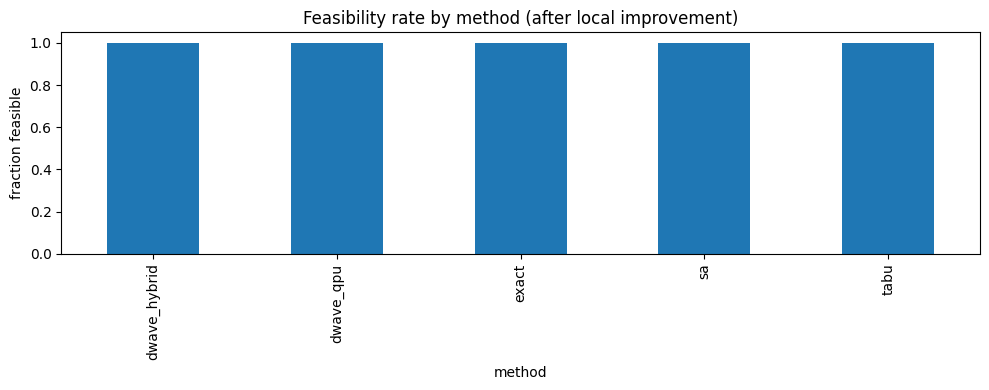

In [38]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
(ok.groupby("method")["imp_feasible"].mean().sort_values(ascending=False)
 .plot(kind="bar", ax=ax))
ax.set_title("Feasibility rate by method (after local improvement)")
ax.set_ylabel("fraction feasible")
plt.tight_layout()
plt.show()


## 5) Quality vs exact (when available)

When `exact` ran, it gives a gold-standard baseline for that instance.  
We use `gap_F_imp_vs_exact = imp_F_markowitz - exact_imp_F_markowitz`.

Lower is better. `0` means you matched exact.


In [39]:
# Gap vs exact is only available when has_exact_ref=True (i.e., exact ran for that instance_key).
# So if exact is capped at max_n=20, you'll only see n<=20 in "gap vs exact" plots.
if "has_exact_ref" in ok.columns:
    print("Exact reference availability by n:")
    display(ok.groupby("n")["has_exact_ref"].mean().rename("fraction_with_exact_ref").reset_index())

Exact reference availability by n:


,n,fraction_with_exact_ref
0,10,1.0
1,20,1.0
2,30,0.0
3,40,0.0


### Summary: gap by method and n

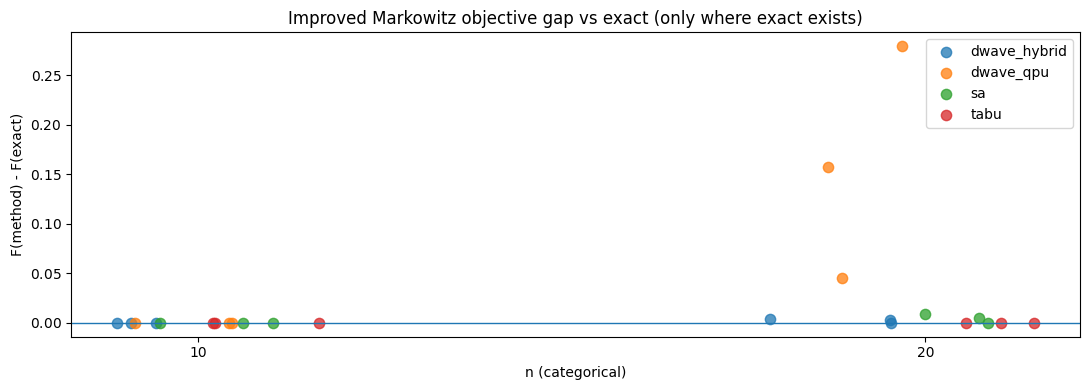

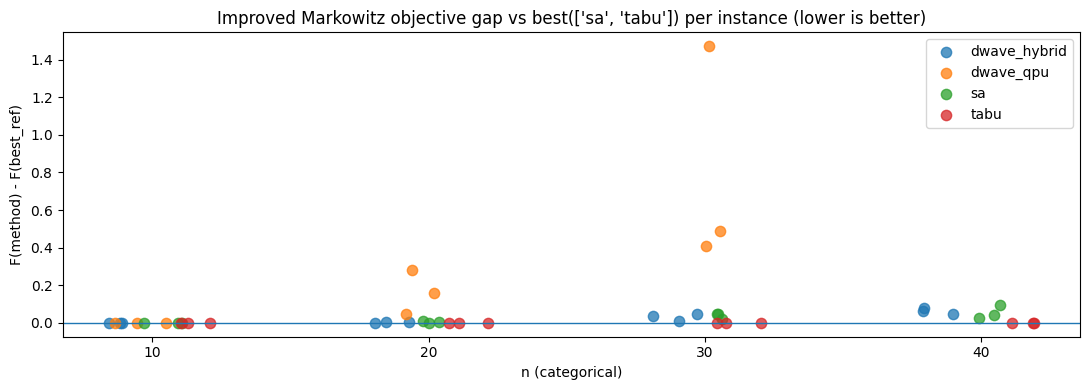

In [40]:
# --- helper for categorical x + jitter ---
def _cat_x_with_jitter(df, n_col="n", method_col="method", jitter=0.10, seed=0):
    rng = np.random.default_rng(seed)
    n_levels = sorted(df[n_col].unique())
    n_to_x = {n:i for i, n in enumerate(n_levels)}          # categorical positions 0..K-1
    x_base = df[n_col].map(n_to_x).astype(float).to_numpy()

    # small deterministic method offsets so methods don't sit on top of each other
    methods = sorted(df[method_col].unique())
    m_to_off = {m: (i - (len(methods)-1)/2)*0.08 for i, m in enumerate(methods)}
    x_off = df[method_col].map(m_to_off).astype(float).to_numpy()

    # random jitter within each category
    x_jit = rng.uniform(-jitter, jitter, size=len(df))
    x = x_base + x_off + x_jit
    return x, n_levels, methods

# 1) Gap vs exact (only where exact exists)
if "gap_F_imp_vs_exact" in ok.columns and "has_exact_ref" in ok.columns:
    df_gap_exact = ok[(ok["method"]!="exact") & ok["has_exact_ref"] & ok["gap_F_imp_vs_exact"].notna()].copy()
    if len(df_gap_exact) == 0:
        print("No non-exact rows with exact-gap info (likely exact did not run, or has_exact_ref is false everywhere).")
    else:
        fig = plt.figure(figsize=(11,4))
        ax = fig.add_subplot(1,1,1)

        x, n_levels, methods = _cat_x_with_jitter(df_gap_exact, jitter=0.10, seed=0)

        for m in methods:
            mask = (df_gap_exact["method"] == m).to_numpy()
            ax.scatter(x[mask], df_gap_exact.loc[mask, "gap_F_imp_vs_exact"],
                       s=55, alpha=0.75, label=m)

        ax.axhline(0.0, linewidth=1)
        ax.set_title("Improved Markowitz objective gap vs exact (only where exact exists)")
        ax.set_xlabel("n (categorical)")
        ax.set_ylabel("F(method) - F(exact)")

        ax.set_xticks(range(len(n_levels)))
        ax.set_xticklabels([str(n) for n in n_levels])

        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))

        ax.legend()
        plt.tight_layout()
        plt.show()

# 2) Gap vs best-known reference (scales beyond exact)
ref_methods = [m for m in ["sa", "tabu"] if m in ok["method"].unique()]
if len(ref_methods) == 0:
    print("No ref_methods (sa/tabu) found; skipping 'gap vs best-known' plot.")
else:
    tmp = ok[ok["method"].isin(ref_methods) & ok["imp_F_markowitz"].notna()].copy()
    best_ref = tmp.groupby("instance_key")["imp_F_markowitz"].min().rename("F_ref")

    df_gap_ref = ok.join(best_ref, on="instance_key")
    df_gap_ref["gap_F_imp_vs_ref"] = df_gap_ref["imp_F_markowitz"] - df_gap_ref["F_ref"]

    plot_df = df_gap_ref[(df_gap_ref["method"]!="exact") & df_gap_ref["gap_F_imp_vs_ref"].notna()].copy()
    if len(plot_df) == 0:
        print("No rows with ref-gap info (unexpected); skipping plot.")
    else:
        fig = plt.figure(figsize=(11,4))
        ax = fig.add_subplot(1,1,1)

        x, n_levels, methods = _cat_x_with_jitter(plot_df, jitter=0.10, seed=1)

        for m in methods:
            mask = (plot_df["method"] == m).to_numpy()
            ax.scatter(x[mask], plot_df.loc[mask, "gap_F_imp_vs_ref"],
                       s=55, alpha=0.75, label=m)

        ax.axhline(0.0, linewidth=1)
        ax.set_title(f"Improved Markowitz objective gap vs best({ref_methods}) per instance (lower is better)")
        ax.set_xlabel("n (categorical)")
        ax.set_ylabel("F(method) - F(best_ref)")

        ax.set_xticks(range(len(n_levels)))
        ax.set_xticklabels([str(n) for n in n_levels])

        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))

        ax.legend()
        plt.tight_layout()
        plt.show()


### Plot: gap vs n (scatter)

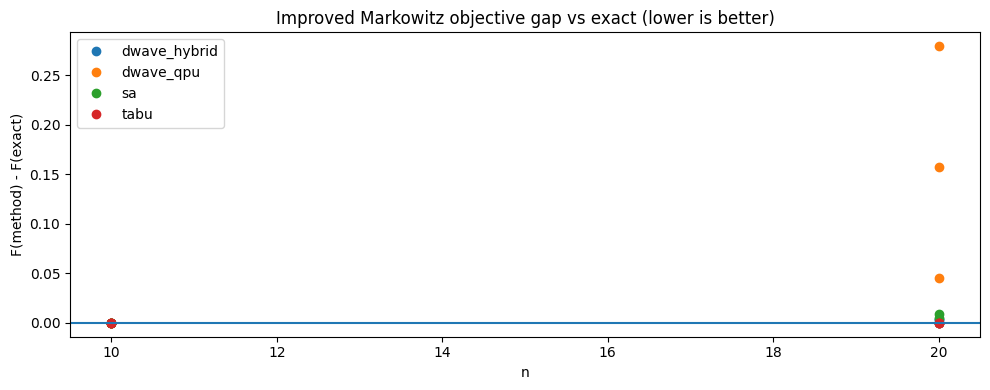

In [41]:
if "gap_F_imp_vs_exact" in ok.columns and "has_exact_ref" in ok.columns:
    df_gap = ok[(ok["method"]!="exact") & ok["has_exact_ref"] & ok["gap_F_imp_vs_exact"].notna()].copy()
    if len(df_gap) == 0:
        print("No non-exact rows with gap info.")
    else:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
        for m in sorted(df_gap["method"].unique()):
            sub = df_gap[df_gap["method"]==m].sort_values("n")
            ax.plot(sub["n"], sub["gap_F_imp_vs_exact"], marker="o", linestyle="None", label=m)
        ax.axhline(0.0)
        ax.set_title("Improved Markowitz objective gap vs exact (lower is better)")
        ax.set_xlabel("n")
        ax.set_ylabel("F(method) - F(exact)")
        ax.legend()
        plt.tight_layout()
        plt.show()


## 6) Runtime scaling

In [42]:
runtime_summary = (ok.groupby(["method","n"])
                   .agg(mean_runtime_s=("runtime_s","mean"),
                        median_runtime_s=("runtime_s","median"),
                        n_runs=("runtime_s","size"))
                   .reset_index()
                   .sort_values(["n","method"]))
runtime_summary


,method,n,mean_runtime_s,median_runtime_s,n_runs
0,dwave_hybrid,10,13.471723,13.205096,3
4,dwave_qpu,10,1.682014,1.777197,3
7,exact,10,0.001488,0.001002,3
9,sa,10,0.965383,0.958756,3
13,tabu,10,8.001444,8.001614,3
1,dwave_hybrid,20,13.368671,13.275095,3
5,dwave_qpu,20,1.829707,1.820910,3
8,exact,20,1.282330,1.280636,3
10,sa,20,43.107876,61.660563,3
14,tabu,20,8.001605,8.001791,3


### Plot: runtime vs n (log y)

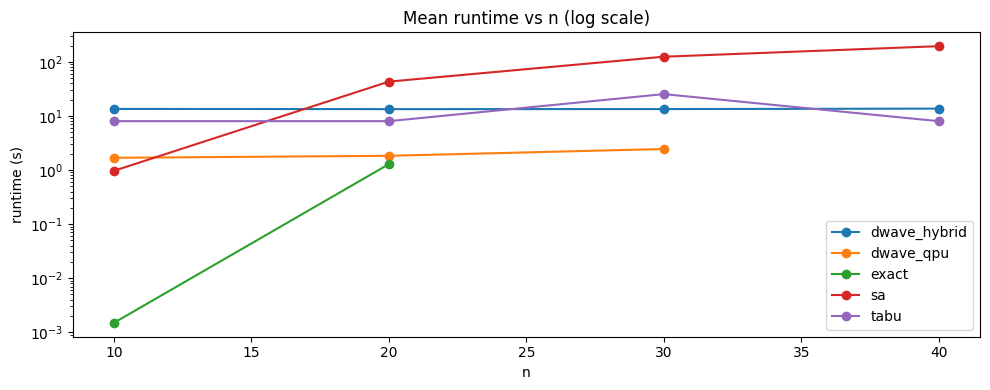

In [43]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
for m in sorted(ok["method"].unique()):
    sub = ok[ok["method"]==m].groupby("n")["runtime_s"].mean().reset_index().sort_values("n")
    ax.plot(sub["n"], sub["runtime_s"], marker="o", label=m)
ax.set_yscale("log")
ax.set_title("Mean runtime vs n (log scale)")
ax.set_xlabel("n")
ax.set_ylabel("runtime (s)")
ax.legend()
plt.tight_layout()
plt.show()


## 7) Did postprocessing help? (raw vs improved)

We compare improvement in QUBO energy and Markowitz objective:
- `raw_F_markowitz - imp_F_markowitz` (positive means improvement)
- `raw_E_qubo - imp_E_qubo`

Note: postprocessing optimizes QUBO energy locally; it should usually not worsen it.


In [44]:
if "raw_F_markowitz" in ok.columns and "imp_F_markowitz" in ok.columns:
    ok["delta_F"] = ok["raw_F_markowitz"] - ok["imp_F_markowitz"]
    ok["delta_E"] = ok["raw_E_qubo"] - ok["imp_E_qubo"]

    improv_summary = (ok.groupby("method")
                      .agg(
                          mean_delta_F=("delta_F","mean"),
                          frac_improved_F=("delta_F", lambda s: float(np.mean(s > 1e-12))),
                          mean_delta_E=("delta_E","mean"),
                          frac_improved_E=("delta_E", lambda s: float(np.mean(s > 1e-12))),
                          n_runs=("delta_F","size"),
                      )
                      .reset_index()
                      .sort_values("frac_improved_E", ascending=False))
    improv_summary
else:
    print("Missing raw/imp columns needed for improvement analysis.")


### Plot: distribution of delta_F by method

In [45]:
# --- Postprocessing improvement (raw_F - imp_F) ---
# If this is identically ~0, it usually means the postprocessing step did not modify the solution
# (already locally optimal under the move set, or the improve routine is effectively a no-op here).

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

if "delta_F" not in ok.columns and ("raw_F_markowitz" in ok.columns) and ("imp_F_markowitz" in ok.columns):
    ok["delta_F"] = ok["raw_F_markowitz"] - ok["imp_F_markowitz"]

if "delta_F" in ok.columns:
    v = ok["delta_F"].dropna().to_numpy()
    if len(v) == 0:
        print("delta_F is empty; skipping plot.")
    else:
        eps = 1e-12
        max_abs = float(np.max(np.abs(v)))
        nnz = int(np.sum(np.abs(v) > eps))
        print(f"delta_F stats: max|delta_F|={max_abs:.3e}, nonzero(|.|>{eps:g}) count={nnz}/{len(v)}")

        if nnz == 0:
            print("delta_F is (numerically) all zeros; skipping the boxplot (not informative).")
        else:
            fig = plt.figure(figsize=(10,4))
            ax = fig.add_subplot(1,1,1)
            methods = sorted(ok["method"].unique())
            data = [ok[ok["method"]==m]["delta_F"].dropna().to_numpy() for m in methods]
            ax.boxplot(data, labels=methods, showfliers=True)
            ax.set_title("Postprocessing improvement in Markowitz objective: raw_F - imp_F")
            ax.set_ylabel("delta_F (positive = better)")

            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))

            plt.tight_layout()
            plt.show()

delta_F stats: max|delta_F|=0.000e+00, nonzero(|.|>1e-12) count=0/51
delta_F is (numerically) all zeros; skipping the boxplot (not informative).


## 8) Optional: QPU/Hybrid deep dive (only if present in JSON)

If you ran QPU/Hybrid in Phase 3, the JSON can contain nested fields like timing and chain breaks.
This section will only do work if such rows exist.


In [46]:
if json_payload is None:
    print("No JSON payload; skipping.")
else:
    rows = json_payload.get("rows", [])
    dfj = pd.DataFrame(rows)
    if len(dfj) == 0 or "engine" not in dfj.columns:
        print("JSON has no usable rows/engine column.")
    else:
        dfj["solver_info_dict"] = dfj["solver_info"].apply(safe_literal_eval) if "solver_info" in dfj.columns else None
        qpu_rows = dfj[dfj["engine"].astype(str).str.contains("dwave.QPU", na=False)].copy()
        hyb_rows = dfj[dfj["engine"].astype(str).str.contains("dwave.Hybrid", na=False)].copy()
        print("QPU rows:", len(qpu_rows), "Hybrid rows:", len(hyb_rows))

        def get_chain_break(d):
            if not isinstance(d, dict):
                return np.nan
            return d.get("chain_break_fraction", np.nan)

        if len(qpu_rows) > 0:
            qpu_rows["chain_break_fraction"] = qpu_rows["solver_info_dict"].map(get_chain_break)
            qpu_rows[["instance_key","method","engine","runtime_s","chain_break_fraction"]].head(10)
        else:
            print("No QPU rows found (likely not run).")


QPU rows: 9 Hybrid rows: 12


## 9) Export clean tables for your report/paper

In [47]:
OUT_SUMMARY_CSV = "phase4_runtime_by_method_n.csv"
OUT_FEAS_CSV = "phase4_feasibility_by_method.csv"
OUT_GAP_CSV = "phase4_gap_by_method_n.csv"

runtime_summary.to_csv(OUT_SUMMARY_CSV, index=False)
feas_summary.to_csv(OUT_FEAS_CSV, index=False)

if "gap_summary" in locals():
    gap_summary.to_csv(OUT_GAP_CSV, index=False)

print("Saved:", OUT_SUMMARY_CSV)
print("Saved:", OUT_FEAS_CSV)
if "gap_summary" in locals():
    print("Saved:", OUT_GAP_CSV)


Saved: phase4_runtime_by_method_n.csv
Saved: phase4_feasibility_by_method.csv


✅ Phase 4 complete.

Next (Phase 5): write the narrative (report / paper-style):
- problem definition + QUBO mapping
- experimental setup + solver configs
- results + key figures
- limitations + next steps (scaling, constraints, real data)
